In [1]:
from utils.IBRS import TRC, RSU, OBU
import time
from decimal import Decimal
import csv

from utils.drawtools import pltbar

In [2]:
with open('./data/VID.csv') as f:
    csv_reader = csv.reader(f)
    head = next(csv_reader)

    VID_POOL = [x for x in csv_reader]

In [3]:
N = 1 # 实验次数，最后结果取平均

---

## [Round1 - OBU Generation] SS512 vs MNT159


In [4]:
def test_obugen(N, L, t_trc):
    recorder = []
    trc = TRC(t_trc, L, 'exp #1')
    start = time.process_time()
    for i in range(N):
        obu = OBU(trc, VID_POOL[i])
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

横坐标： 二叉树的深度，`range(10, 21)`

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

---

In [5]:
types = ['MNT159', 'SS512']
time_cost = [[], []]
for i, t in enumerate(types):
    for j in range(10, 13):
        result = test_obugen(N, j, t)
        time_cost[i].append(float(result))
time_cost

[[2.54, 3.55, 2.56], [17.19, 18.44, 17.39]]

IndexError: list index out of range

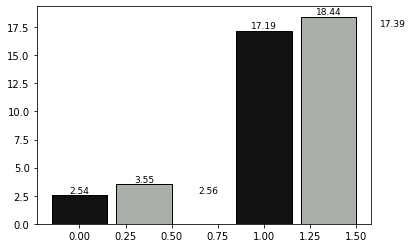

In [6]:
data = [(x,y) for x, y in zip(*time_cost)]
xlabels = range(10, 13)
pltbar(2, 0.35, data, types, xlabels)

In [ ]:
a = [Decimal('2.47'), Decimal('2.56'), Decimal('2.57'), Decimal('2.65'), Decimal('2.88'), Decimal('3.90'), Decimal('3.84'), Decimal('7.60'), Decimal('9.21'), Decimal('22.61'), Decimal('28.94')]
b = [Decimal('17.13'), Decimal('18.34'), Decimal('17.31'), Decimal('17.36'), Decimal('17.66'), Decimal('18.00'), Decimal('19.20'), Decimal('20.85'), Decimal('24.26'), Decimal('29.85'), Decimal('43.14')]

In [ ]:
[(float(x), float(y)) for x,y in zip(a, b)]